# 📈 Moving Average Analysis

**Purpose**: Calculate and visualize multiple moving averages (20, 50, 75, 100, 125, 150, 175, 200, 225, 250)

**Data Source**: Local SQLite database with stock price data

**Moving Average Periods**: 20, 50, then increment by 25 up to 250

---

## 📦 Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import yfinance as yf
import sqlite3
import warnings
warnings.filterwarnings('ignore')

# Set plotting style to white background
plt.style.use('default')
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.edgecolor'] = 'black'
plt.rcParams['axes.labelcolor'] = 'black'
plt.rcParams['text.color'] = 'black'
plt.rcParams['xtick.color'] = 'black'
plt.rcParams['ytick.color'] = 'black'

print("📦 Libraries imported successfully with WHITE background theme!")

📦 Libraries imported successfully with WHITE background theme!


## ⚙️ Configuration

In [2]:
# Analysis configuration
SYMBOL = 'QQQ'  # Default symbol - can be changed
DAYS = 1000     # Number of days of data to analyze
TIMEFRAME = '1D' # Daily data

# Moving average periods: 20, 50, then increment by 25 until 250
MA_PERIODS = [20, 50] + list(range(75, 275, 25))
print(f"📊 Moving Average Periods: {MA_PERIODS}")

# Color palette for different moving averages
colors = plt.cm.tab20(np.linspace(0, 1, len(MA_PERIODS)))
MA_COLORS = {period: colors[i] for i, period in enumerate(MA_PERIODS)}

print(f"🎯 Analysis Configuration:")
print(f"   Symbol: {SYMBOL}")
print(f"   Days: {DAYS}")
print(f"   Timeframe: {TIMEFRAME}")
print(f"   MA Periods: {len(MA_PERIODS)} moving averages")

📊 Moving Average Periods: [20, 50, 75, 100, 125, 150, 175, 200, 225, 250]
🎯 Analysis Configuration:
   Symbol: QQQ
   Days: 1000
   Timeframe: 1D
   MA Periods: 10 moving averages


## 📊 Data Loading Functions

In [3]:
def load_stock_data_from_db(symbol, days=365, timeframe='1D', filter_premarket=True):
    """Load stock data from the local SQLite database"""
    try:
        # Connect to the database
        db_path = 'data/stock-data.db'
        conn = sqlite3.connect(db_path)

        # Query to get the most recent data
        query = """
        SELECT datetime(timestamp, 'unixepoch') as date, open, high, low, close, volume
        FROM market_data
        WHERE symbol = ? AND timeframe = ?
        ORDER BY timestamp DESC
        LIMIT ?
        """

        print(f"📊 Loading {symbol} data from local database (timeframe: {timeframe})...")

        # Load data
        df = pd.read_sql_query(query, conn, params=(symbol, timeframe, days))

        if df.empty:
            print(f"❌ No data found for {symbol} with timeframe {timeframe}")
            return None

        # Convert date column and sort chronologically
        df['date'] = pd.to_datetime(df['date'])
        df = df.sort_values('date').reset_index(drop=True)

        # Filter premarket data if requested (skip for daily data)
        if filter_premarket and timeframe != '1D':
            # Keep only regular market hours data (only for intraday data)
            df = df[df['date'].dt.time >= pd.Timestamp('09:30').time()]
            df = df[df['date'].dt.time <= pd.Timestamp('16:00').time()]

        conn.close()

        print(f"✅ Loaded {len(df)} records for {symbol}")
        print(f"📅 Date range: {df['date'].min().strftime('%Y-%m-%d')} to {df['date'].max().strftime('%Y-%m-%d')}")

        return df

    except Exception as e:
        print(f"❌ Error loading data: {e}")
        return None

def calculate_moving_averages(df, periods):
    """Calculate multiple moving averages for the given periods"""
    df_with_ma = df.copy()

    for period in periods:
        ma_col = f'MA_{period}'
        df_with_ma[ma_col] = df_with_ma['close'].rolling(window=period, min_periods=1).mean()
        print(f"✅ Calculated {period}-day moving average")

    return df_with_ma

print("📊 Data loading functions defined successfully!")

📊 Data loading functions defined successfully!


## 📈 Load Data and Calculate Moving Averages

In [4]:
# Load stock data
df = load_stock_data_from_db(SYMBOL, days=DAYS, timeframe=TIMEFRAME)

if df is not None:
    print(f"\n📊 Data Summary:")
    print(f"   Records: {len(df)}")
    print(f"   Price range: ${df['close'].min():.2f} - ${df['close'].max():.2f}")
    print(f"   Current price: ${df['close'].iloc[-1]:.2f}")

    # Calculate all moving averages
    print(f"\n🔄 Calculating moving averages...")
    df_ma = calculate_moving_averages(df, MA_PERIODS)

    print(f"\n✅ Moving averages calculated successfully!")
    print(f"📊 Columns: {list(df_ma.columns)}")
else:
    print("❌ Failed to load data. Please check the database connection and symbol.")

📊 Loading QQQ data from local database (timeframe: 1D)...
✅ Loaded 1000 records for QQQ
📅 Date range: 2021-11-02 to 2025-09-04

📊 Data Summary:
   Records: 1000
   Price range: $260.10 - $580.34
   Current price: $575.23

🔄 Calculating moving averages...
✅ Calculated 20-day moving average
✅ Calculated 50-day moving average
✅ Calculated 75-day moving average
✅ Calculated 100-day moving average
✅ Calculated 125-day moving average
✅ Calculated 150-day moving average
✅ Calculated 175-day moving average
✅ Calculated 200-day moving average
✅ Calculated 225-day moving average
✅ Calculated 250-day moving average

✅ Moving averages calculated successfully!
📊 Columns: ['date', 'open', 'high', 'low', 'close', 'volume', 'MA_20', 'MA_50', 'MA_75', 'MA_100', 'MA_125', 'MA_150', 'MA_175', 'MA_200', 'MA_225', 'MA_250']


## 📊 Visualization Functions

In [5]:
def plot_price_with_moving_averages(df, symbol, periods, recent_days=252):
    """Plot price with multiple moving averages"""
    # Use recent data for better visualization
    df_recent = df.tail(recent_days) if len(df) > recent_days else df

    plt.figure(figsize=(16, 10))

    # Plot price
    plt.plot(df_recent['date'], df_recent['close'],
             label=f'{symbol} Price', linewidth=2, color='black', alpha=0.8)

    # Plot moving averages
    for period in periods:
        ma_col = f'MA_{period}'
        if ma_col in df_recent.columns:
            plt.plot(df_recent['date'], df_recent[ma_col],
                    label=f'MA-{period}', alpha=0.7, linewidth=1.5,
                    color=MA_COLORS[period])

    plt.title(f'{symbol} Price with Moving Averages (Last {len(df_recent)} days)', fontsize=16, fontweight='bold')
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Price ($)', fontsize=12)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def plot_ma_distance_analysis(df, symbol, periods):
    """Plot the distance of price from each moving average"""
    # Calculate percentage distance from each MA
    df_analysis = df.copy()

    for period in periods:
        ma_col = f'MA_{period}'
        distance_col = f'Distance_MA_{period}'
        if ma_col in df_analysis.columns:
            df_analysis[distance_col] = ((df_analysis['close'] - df_analysis[ma_col]) / df_analysis[ma_col] * 100)

    # Use recent data
    df_recent = df_analysis.tail(252) if len(df_analysis) > 252 else df_analysis

    plt.figure(figsize=(16, 8))

    for period in periods:
        distance_col = f'Distance_MA_{period}'
        if distance_col in df_recent.columns:
            plt.plot(df_recent['date'], df_recent[distance_col],
                    label=f'Distance from MA-{period}', alpha=0.7,
                    color=MA_COLORS[period])

    plt.axhline(y=0, color='black', linestyle='-', alpha=0.5)
    plt.title(f'{symbol} - Percentage Distance from Moving Averages', fontsize=16, fontweight='bold')
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Distance from MA (%)', fontsize=12)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def plot_ma_crossover_signals(df, symbol, fast_ma=20, slow_ma=50):
    """Plot moving average crossover signals"""
    df_signals = df.copy()

    # Calculate crossover signals
    fast_col = f'MA_{fast_ma}'
    slow_col = f'MA_{slow_ma}'

    if fast_col in df_signals.columns and slow_col in df_signals.columns:
        # Golden cross: fast MA crosses above slow MA
        df_signals['golden_cross'] = (
            (df_signals[fast_col] > df_signals[slow_col]) &
            (df_signals[fast_col].shift(1) <= df_signals[slow_col].shift(1))
        )

        # Death cross: fast MA crosses below slow MA
        df_signals['death_cross'] = (
            (df_signals[fast_col] < df_signals[slow_col]) &
            (df_signals[fast_col].shift(1) >= df_signals[slow_col].shift(1))
        )

        # Use recent data
        df_recent = df_signals.tail(252) if len(df_signals) > 252 else df_signals

        plt.figure(figsize=(16, 10))

        # Plot price and MAs
        plt.plot(df_recent['date'], df_recent['close'],
                label=f'{symbol} Price', linewidth=2, color='black', alpha=0.8)
        plt.plot(df_recent['date'], df_recent[fast_col],
                label=f'MA-{fast_ma}', linewidth=2, color='blue')
        plt.plot(df_recent['date'], df_recent[slow_col],
                label=f'MA-{slow_ma}', linewidth=2, color='red')

        # Mark crossover points
        golden_crosses = df_recent[df_recent['golden_cross']]
        death_crosses = df_recent[df_recent['death_cross']]

        if not golden_crosses.empty:
            plt.scatter(golden_crosses['date'], golden_crosses['close'],
                       color='green', marker='^', s=100, label='Golden Cross', zorder=5)

        if not death_crosses.empty:
            plt.scatter(death_crosses['date'], death_crosses['close'],
                       color='red', marker='v', s=100, label='Death Cross', zorder=5)

        plt.title(f'{symbol} - MA Crossover Signals (MA-{fast_ma} vs MA-{slow_ma})',
                 fontsize=16, fontweight='bold')
        plt.xlabel('Date', fontsize=12)
        plt.ylabel('Price ($)', fontsize=12)
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

        # Print crossover summary
        print(f"\n📊 Crossover Summary (MA-{fast_ma} vs MA-{slow_ma}):")
        print(f"   Golden Crosses: {golden_crosses.shape[0]}")
        print(f"   Death Crosses: {death_crosses.shape[0]}")

print("📊 Visualization functions defined successfully!")

📊 Visualization functions defined successfully!


## 📈 Moving Average Analysis

🔍 Analyzing QQQ with 10 moving averages...

📊 Current Analysis for QQQ:
   Current Price: $575.23

📈 Moving Averages:
   MA- 20: $ 573.10 (🟢 Above  +0.4%)
   MA- 50: $ 565.48 (🟢 Above  +1.7%)
   MA- 75: $ 553.11 (🟢 Above  +4.0%)
   MA-100: $ 536.99 (🟢 Above  +7.1%)
   MA-125: $ 522.43 (🟢 Above +10.1%)
   MA-150: $ 520.85 (🟢 Above +10.4%)
   MA-175: $ 520.69 (🟢 Above +10.5%)
   MA-200: $ 520.80 (🟢 Above +10.5%)
   MA-225: $ 518.77 (🟢 Above +10.9%)
   MA-250: $ 515.72 (🟢 Above +11.5%)

📊 Generating visualizations...


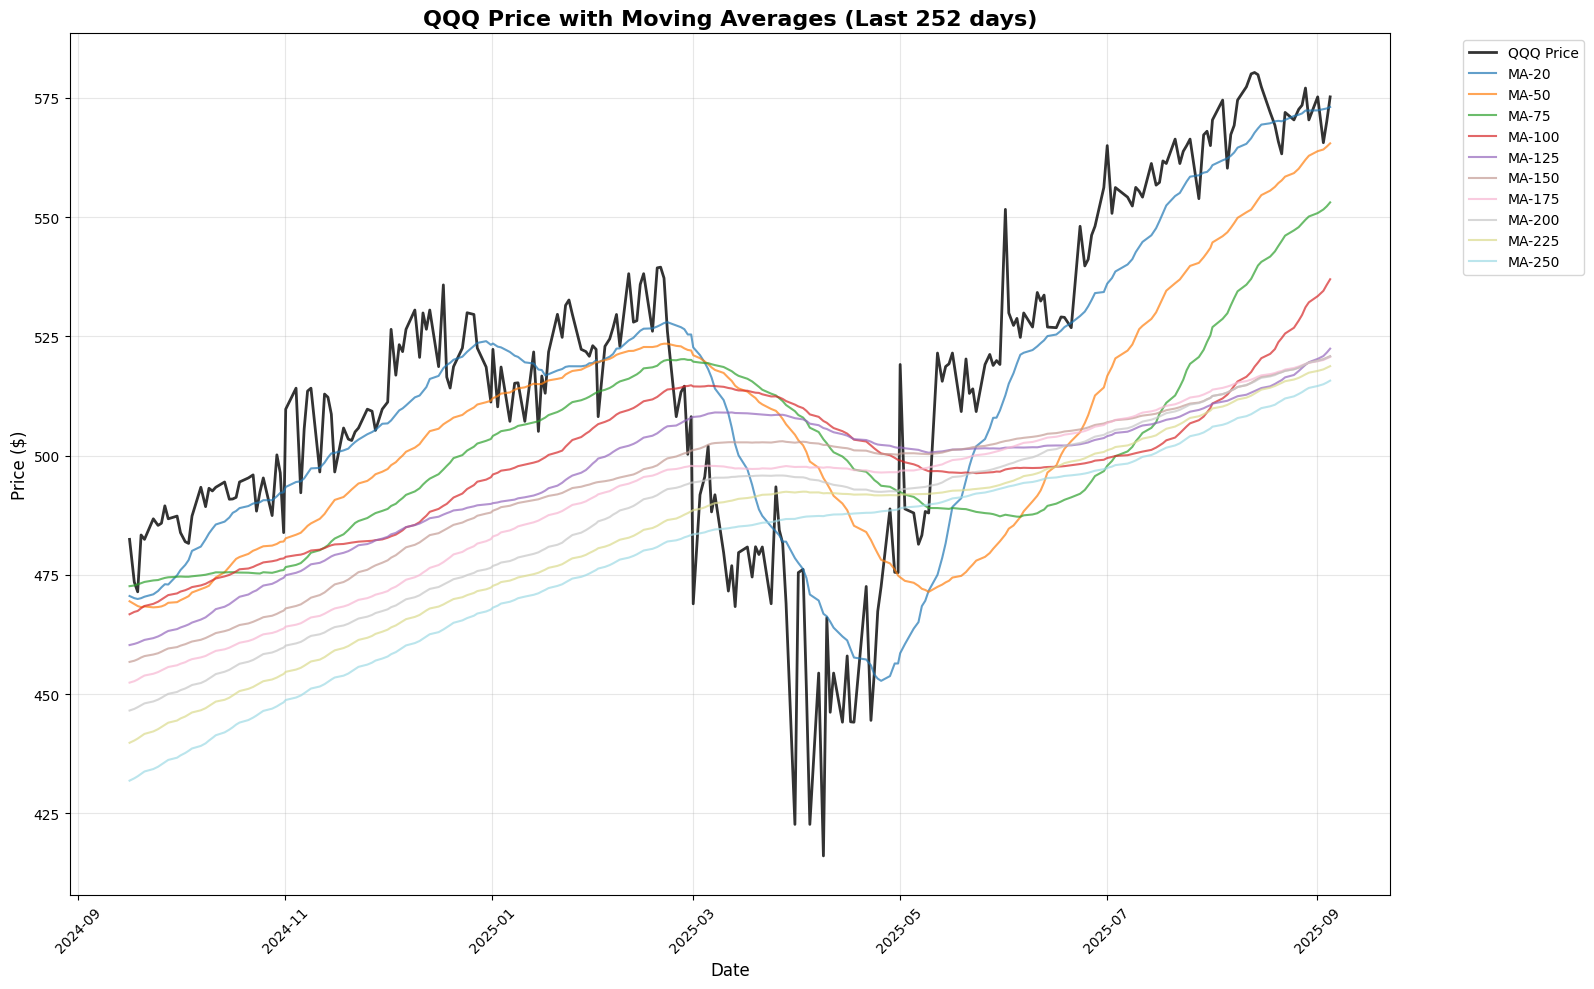

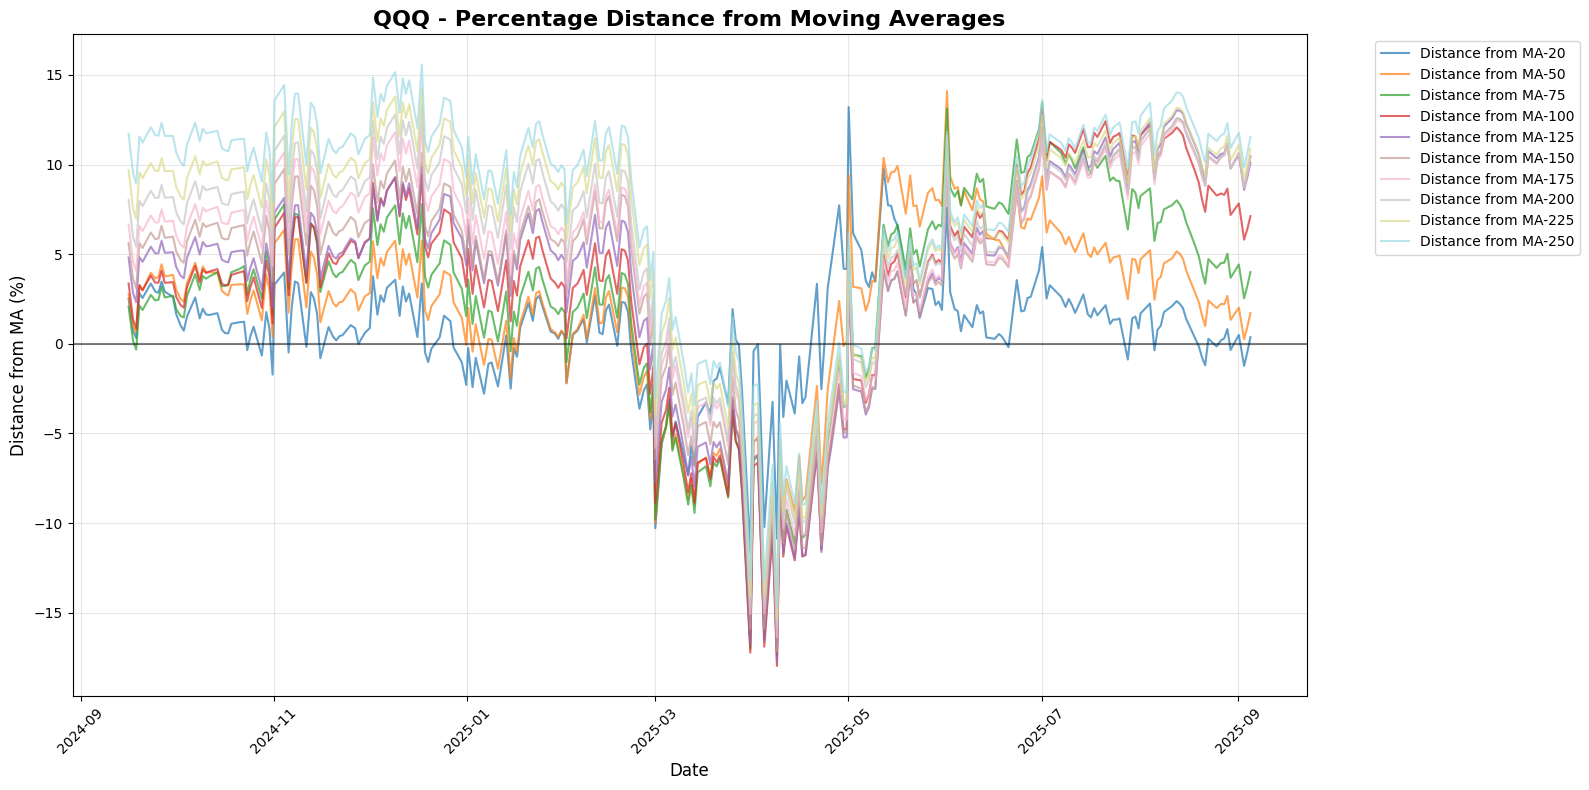

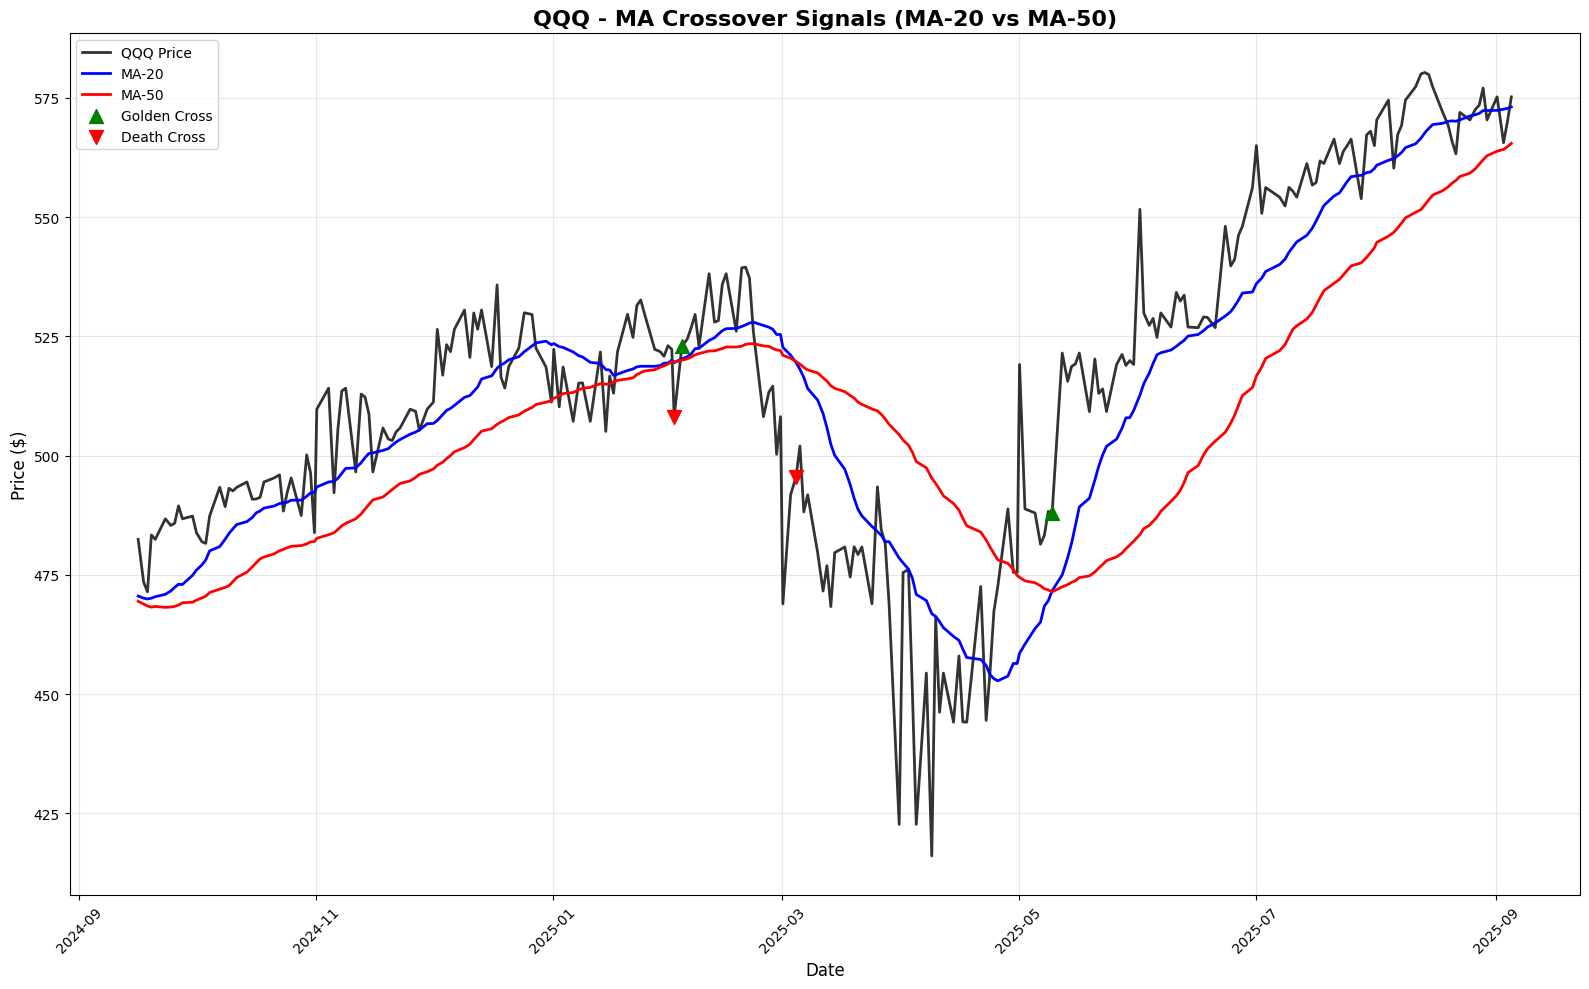


📊 Crossover Summary (MA-20 vs MA-50):
   Golden Crosses: 2
   Death Crosses: 2


In [6]:
if df is not None and 'df_ma' in locals():
    print(f"🔍 Analyzing {SYMBOL} with {len(MA_PERIODS)} moving averages...\n")

    # Current prices and moving averages
    current_price = df_ma['close'].iloc[-1]
    print(f"📊 Current Analysis for {SYMBOL}:")
    print(f"   Current Price: ${current_price:.2f}")
    print(f"\n📈 Moving Averages:")

    for period in MA_PERIODS:
        ma_col = f'MA_{period}'
        if ma_col in df_ma.columns:
            current_ma = df_ma[ma_col].iloc[-1]
            distance = ((current_price - current_ma) / current_ma * 100)
            trend = "🟢 Above" if distance > 0 else "🔴 Below"
            print(f"   MA-{period:3d}: ${current_ma:7.2f} ({trend} {distance:+5.1f}%)")

    # Plot all moving averages
    print(f"\n📊 Generating visualizations...")
    plot_price_with_moving_averages(df_ma, SYMBOL, MA_PERIODS)

    # Plot distance analysis
    plot_ma_distance_analysis(df_ma, SYMBOL, MA_PERIODS)

    # Plot crossover signals for 20/50 MA
    plot_ma_crossover_signals(df_ma, SYMBOL, 20, 50)

else:
    print("❌ Data not available for analysis")

## 📊 Moving Average Summary Table

In [7]:
if df is not None and 'df_ma' in locals():
    # Create summary table
    summary_data = []
    current_price = df_ma['close'].iloc[-1]

    for period in MA_PERIODS:
        ma_col = f'MA_{period}'
        if ma_col in df_ma.columns:
            current_ma = df_ma[ma_col].iloc[-1]
            distance = ((current_price - current_ma) / current_ma * 100)
            trend = "Above" if distance > 0 else "Below"

            summary_data.append({
                'Period': f'MA-{period}',
                'Value': f'${current_ma:.2f}',
                'Distance (%)': f'{distance:+.1f}%',
                'Position': trend
            })

    summary_df = pd.DataFrame(summary_data)

    print(f"📊 {SYMBOL} Moving Average Summary (Current Price: ${current_price:.2f})")
    print("=" * 60)
    print(summary_df.to_string(index=False))

    # Calculate support and resistance levels
    above_price = []
    below_price = []

    for period in MA_PERIODS:
        ma_col = f'MA_{period}'
        if ma_col in df_ma.columns:
            current_ma = df_ma[ma_col].iloc[-1]
            if current_ma > current_price:
                above_price.append((period, current_ma))
            else:
                below_price.append((period, current_ma))

    print(f"\n🎯 Technical Levels Analysis:")

    if above_price:
        closest_resistance = min(above_price, key=lambda x: x[1])
        print(f"   Nearest Resistance: MA-{closest_resistance[0]} at ${closest_resistance[1]:.2f}")

    if below_price:
        closest_support = max(below_price, key=lambda x: x[1])
        print(f"   Nearest Support: MA-{closest_support[0]} at ${closest_support[1]:.2f}")

    # Moving average alignment
    ma_values = [(period, df_ma[f'MA_{period}'].iloc[-1]) for period in MA_PERIODS if f'MA_{period}' in df_ma.columns]
    ma_values.sort(key=lambda x: x[1], reverse=True)  # Sort by value, descending

    print(f"\n📈 Moving Average Ranking (High to Low):")
    for i, (period, value) in enumerate(ma_values[:5]):
        print(f"   {i+1}. MA-{period}: ${value:.2f}")
else:
    print("❌ Summary not available - data not loaded")

📊 QQQ Moving Average Summary (Current Price: $575.23)
Period   Value Distance (%) Position
 MA-20 $573.10        +0.4%    Above
 MA-50 $565.48        +1.7%    Above
 MA-75 $553.11        +4.0%    Above
MA-100 $536.99        +7.1%    Above
MA-125 $522.43       +10.1%    Above
MA-150 $520.85       +10.4%    Above
MA-175 $520.69       +10.5%    Above
MA-200 $520.80       +10.5%    Above
MA-225 $518.77       +10.9%    Above
MA-250 $515.72       +11.5%    Above

🎯 Technical Levels Analysis:
   Nearest Support: MA-20 at $573.10

📈 Moving Average Ranking (High to Low):
   1. MA-20: $573.10
   2. MA-50: $565.48
   3. MA-75: $553.11
   4. MA-100: $536.99
   5. MA-125: $522.43


## 🔧 Custom Analysis (Change Symbol/Parameters Here)

🔍 Custom Analysis for AAPL...

📊 Loading AAPL data from local database (timeframe: 1D)...
✅ Loaded 500 records for AAPL
📅 Date range: 2024-01-30 to 2025-09-02
✅ Calculated 20-day moving average
✅ Calculated 50-day moving average
✅ Calculated 75-day moving average
✅ Calculated 100-day moving average
✅ Calculated 125-day moving average
✅ Calculated 150-day moving average
✅ Calculated 175-day moving average
✅ Calculated 200-day moving average
✅ Calculated 225-day moving average
✅ Calculated 250-day moving average


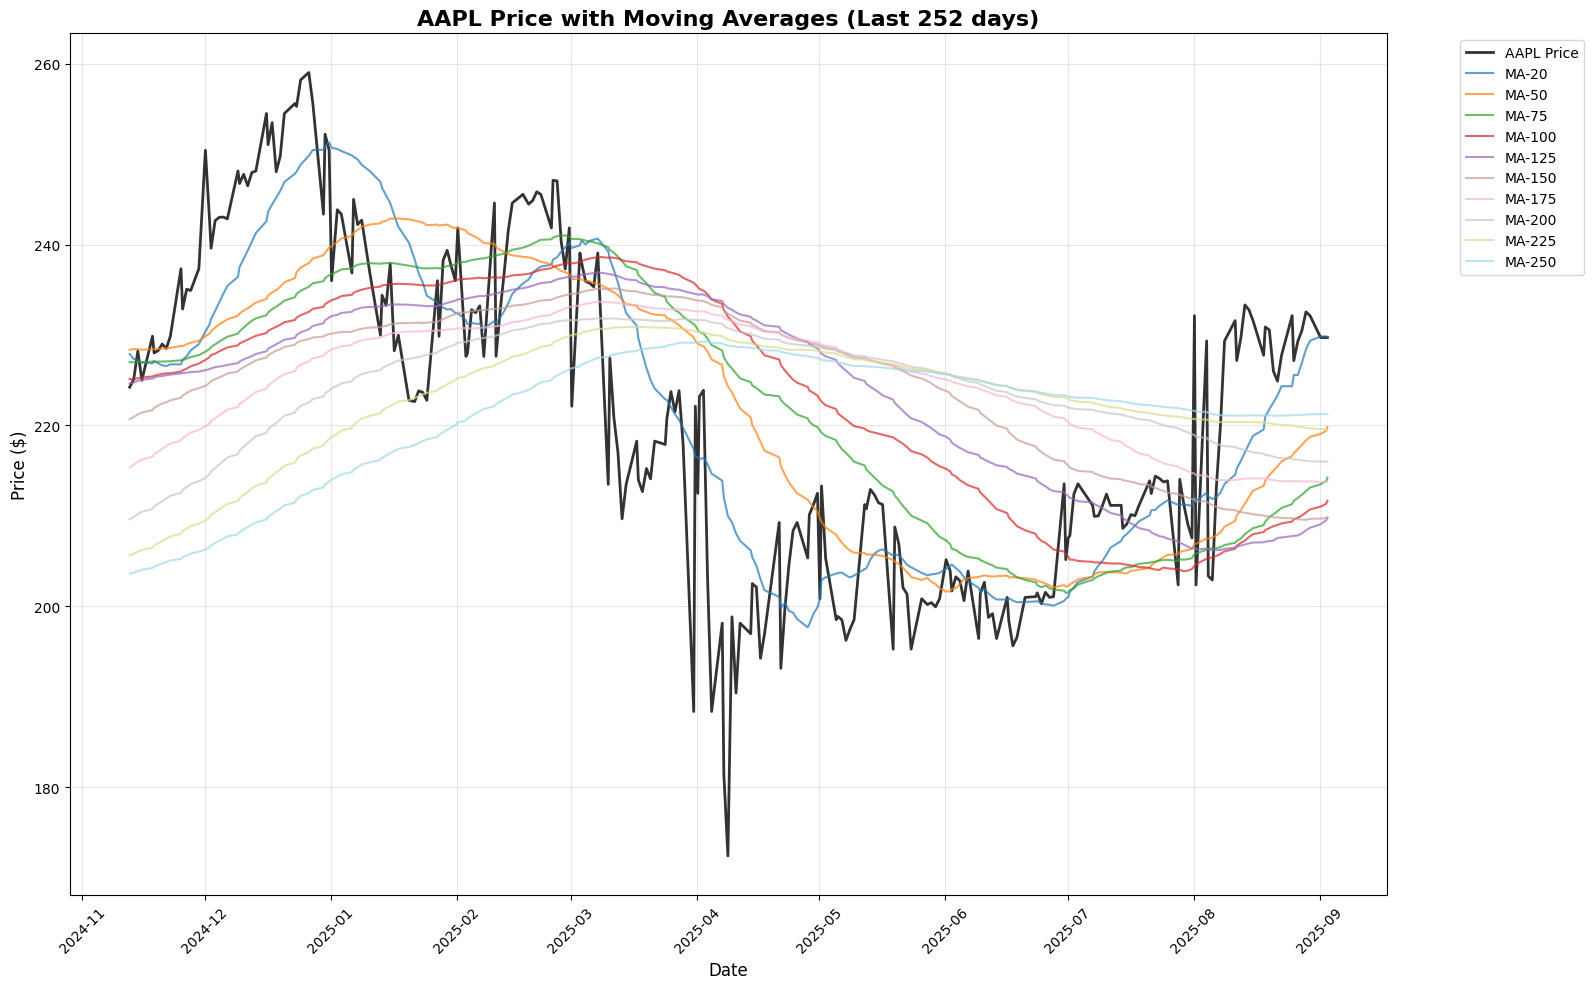

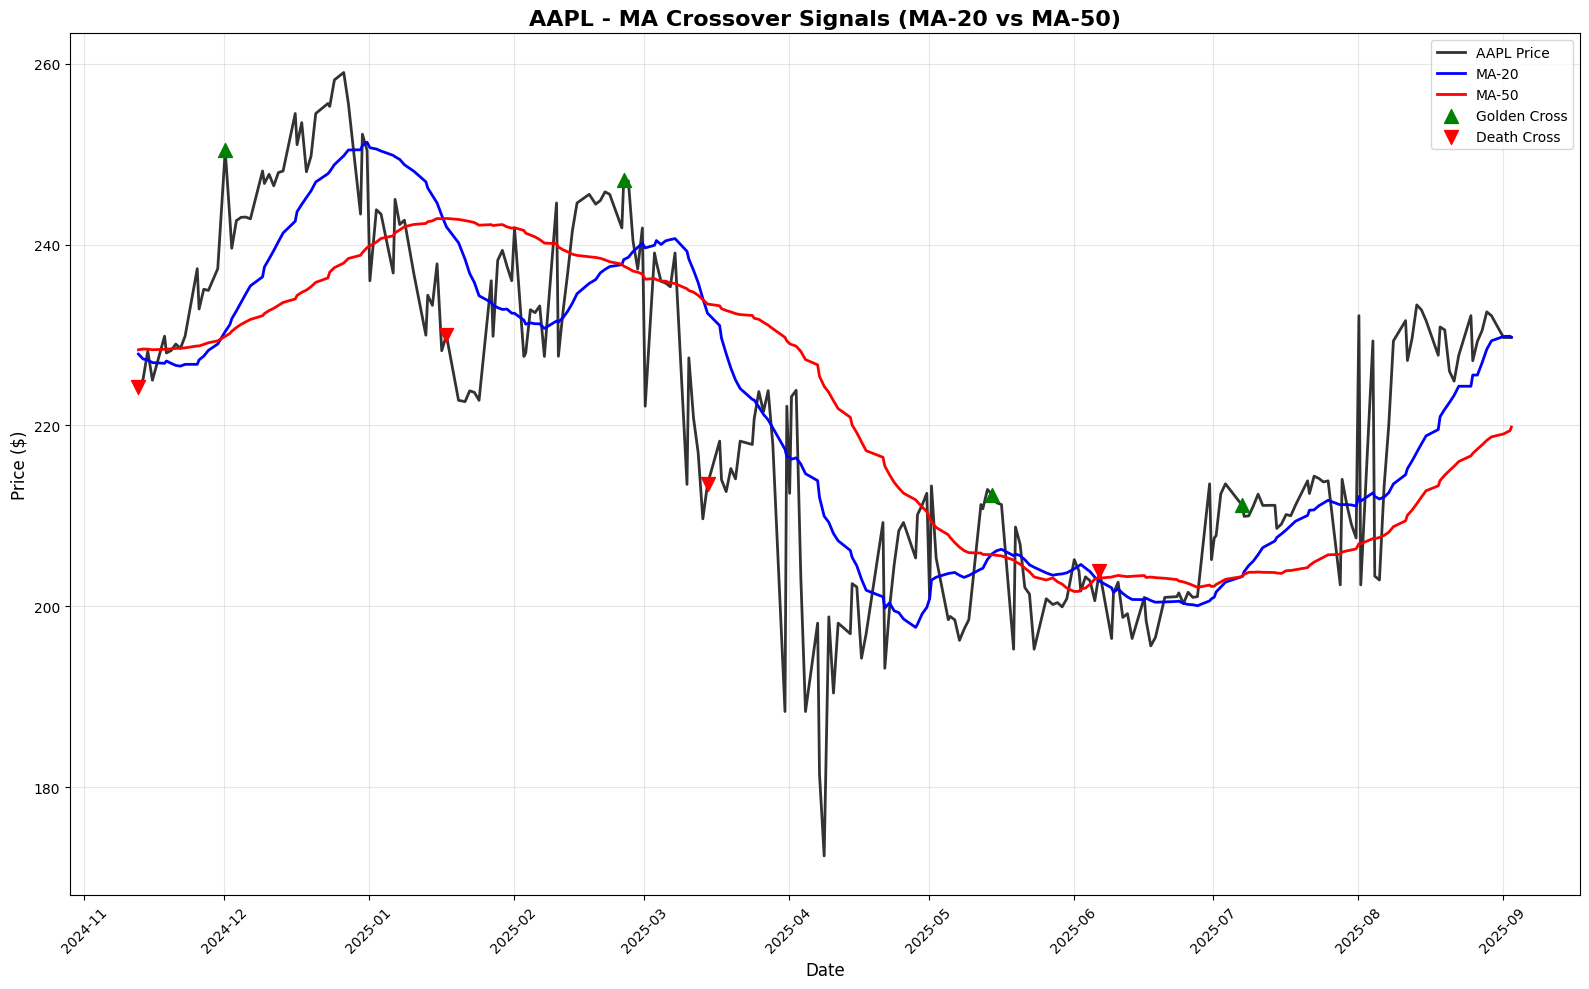


📊 Crossover Summary (MA-20 vs MA-50):
   Golden Crosses: 4
   Death Crosses: 4

📊 Quick Summary for AAPL:
   Current Price: $229.72
   Above 9/10 moving averages
   Below 1/10 moving averages
   📈 Overall Trend: BULLISH (above 90% of MAs)


In [8]:
# Customize analysis here
CUSTOM_SYMBOL = 'AAPL'  # Change this to analyze different symbols
CUSTOM_DAYS = 500       # Change number of days

# Load and analyze custom symbol
print(f"🔍 Custom Analysis for {CUSTOM_SYMBOL}...\n")
custom_df = load_stock_data_from_db(CUSTOM_SYMBOL, days=CUSTOM_DAYS, timeframe=TIMEFRAME)

if custom_df is not None:
    # Calculate moving averages
    custom_df_ma = calculate_moving_averages(custom_df, MA_PERIODS)

    # Generate visualizations
    plot_price_with_moving_averages(custom_df_ma, CUSTOM_SYMBOL, MA_PERIODS, recent_days=252)
    plot_ma_crossover_signals(custom_df_ma, CUSTOM_SYMBOL, 20, 50)

    # Quick summary
    current_price = custom_df_ma['close'].iloc[-1]
    print(f"\n📊 Quick Summary for {CUSTOM_SYMBOL}:")
    print(f"   Current Price: ${current_price:.2f}")

    # Count how many MAs price is above/below
    above_count = 0
    below_count = 0

    for period in MA_PERIODS:
        ma_col = f'MA_{period}'
        if ma_col in custom_df_ma.columns:
            ma_value = custom_df_ma[ma_col].iloc[-1]
            if current_price > ma_value:
                above_count += 1
            else:
                below_count += 1

    print(f"   Above {above_count}/{len(MA_PERIODS)} moving averages")
    print(f"   Below {below_count}/{len(MA_PERIODS)} moving averages")

    if above_count > below_count:
        print(f"   📈 Overall Trend: BULLISH (above {above_count/len(MA_PERIODS)*100:.0f}% of MAs)")
    else:
        print(f"   📉 Overall Trend: BEARISH (below {below_count/len(MA_PERIODS)*100:.0f}% of MAs)")

else:
    print(f"❌ Unable to load data for {CUSTOM_SYMBOL}")